# Investigation of representation drift through reduced model

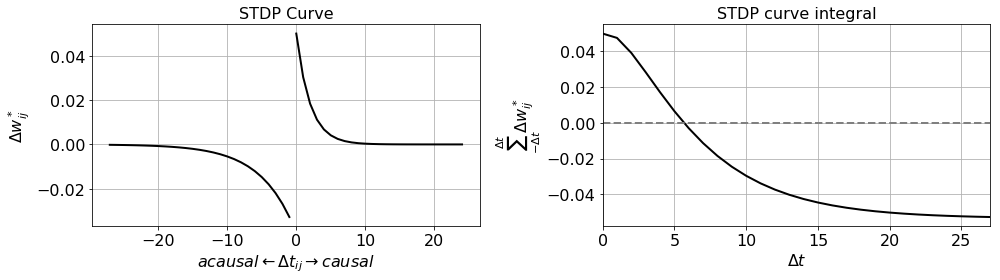

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

from aux import r_tile, c_tile, Generic
from disp import set_font_size, set_color, fast_fig
from ntwk import BinarySTDPNtwk

cc = np.concatenate


# ADAPTATION
THT_S = 1
T_THT = 4
A_THT = 1

# PLASTICITY
A_P = .05
A_M = -.04
T_P = 2
T_M = 5
T_STDP_MAX = 5*max(T_P, T_M)

W_MIN = THT_S/50 + .0001
W_MAX = THT_S/4 + .0001

# STDP HELPER VARS
T_STDP_P = np.arange(T_STDP_MAX, dtype=int)
T_STDP_M = np.arange(-T_STDP_MAX-2, 0, dtype=int)
D_W_S_P = A_P*np.exp(-T_STDP_P/T_P)
D_W_S_M = A_M*np.exp(T_STDP_M/T_M)

T_STDP = cc([T_STDP_M, T_STDP_P])
D_W_S = cc([D_W_S_M, D_W_S_P])

# PLOT STDP CURVE AND ITS INTEGRAL
fig, axs = plt.subplots(1, 2, figsize=(14, 4), tight_layout=True)
axs[0].plot(T_STDP_M, D_W_S_M, lw=2, c='k')
axs[0].plot(T_STDP_P, D_W_S_P, lw=2, c='k')
axs[0].set_xlabel(r'$acausal \leftarrow \Delta t_{ij} \rightarrow causal$')
axs[0].set_ylabel(r'$\Delta w^*_{ij}$')
axs[0].set_title('STDP Curve')

T_STDP_INT = np.arange(np.max(np.abs(T_STDP)) + 1)
D_W_S_TMP = np.zeros(T_STDP_INT.shape)
D_W_S_TMP[T_STDP_P] = D_W_S_P
D_W_S_TMP[-T_STDP_M] += D_W_S_M
D_W_S_INT = D_W_S_TMP.cumsum()

axs[1].plot(T_STDP_INT, D_W_S_INT, c='k', lw=2)
axs[1].axhline(0, color='gray', ls='--', lw=2)
axs[1].set_xlim(0, T_STDP_INT[-1])
axs[1].set_xlabel(r'$\Delta t$')
axs[1].set_ylabel(r'$\sum_{-\Delta t}^{\Delta t} \Delta w_{ij}^* $')
axs[1].set_title('STDP curve integral')

for ax in axs:
    ax.grid()
    set_font_size(ax, 16)

# STDP sanity checks

Paired pulse conditioning with different pulse intervals

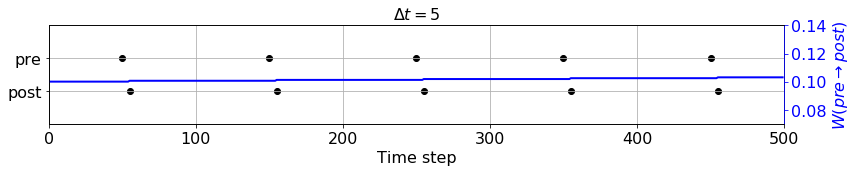

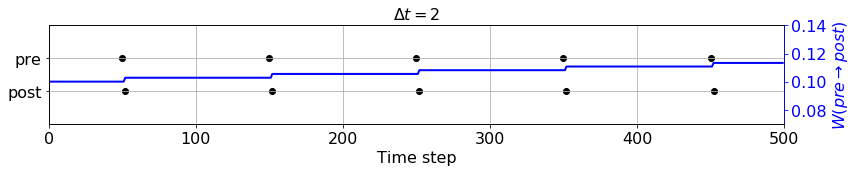

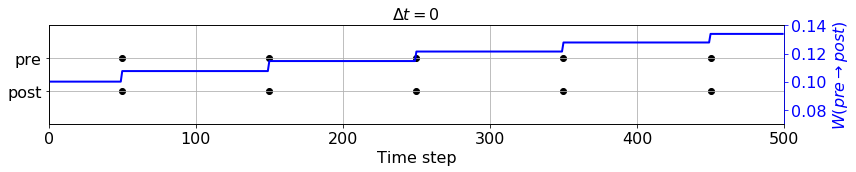

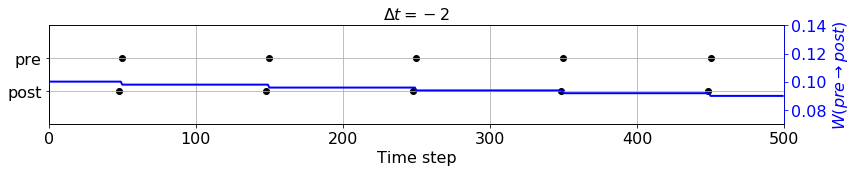

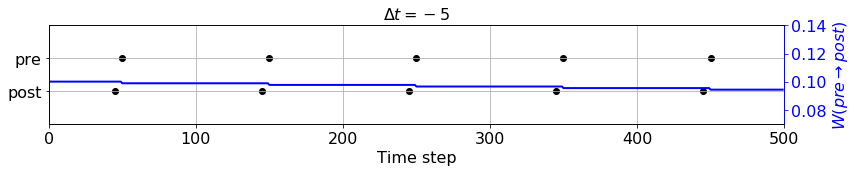

In [2]:
# set up weights
cxn = np.array([[0, 0], [1, 0]], dtype=bool)
w = np.array([[0, 0], [.1, 0]])

# make ntwk
ntwk = BinarySTDPNtwk(
    cxn=cxn,
    w_0=w,
    tht_s=1,
    t_tht=1,
    a_tht=0,
    n_max=2,
    t_stdp=cc([T_STDP_M, T_STDP_P]),
    d_w_s=cc([D_W_S_M, D_W_S_P]),
    w_min=W_MIN,
    w_max=W_MAX)

# loop over pulse timings
itvl = 100
t_0 = 50
d_t = [-5, -2, 0, 2, 5][::-1]

for d_t_ in d_t:
    # set up inputs
    i_ext = np.zeros((500, 2))
    
    for t_ in np.arange(t_0, len(i_ext), itvl):
        i_ext[t_, 0] = 1.5  # presynpatic
        i_ext[t_+d_t_, 1] = 1.5  # post synaptic
        
    # run ntwk
    rslt = ntwk.run(
        i_ext=i_ext,
        t_save_w=np.arange(1, len(i_ext)))
    
    # plot results
    fig, ax = plt.subplots(1, 1, figsize=(12, 2.5), tight_layout=True)
    
    # spikes
    ax.scatter(*rslt.spks.nonzero(), c='k')
    
    ax.set_xlim(0, len(i_ext))
    ax.set_ylim(2, -1)
    
    ax.set_xlabel('Time step')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['pre', 'post'])
    
    ax.set_title(r'$\Delta t = {}$'.format(d_t_))
    
    ax.grid()
    
    # w
    ax_twin = ax.twinx()
    ax_twin.plot(np.arange(1, len(i_ext)), [rslt.ws[t_][1, 0] for t_ in np.arange(1, len(i_ext))], lw=2, c='b')
    
    ax_twin.set_xlim(0, len(i_ext))
    ax_twin.set_ylim(.07, .14)
    ax_twin.set_ylabel(r'$W(pre \rightarrow post)$')
    
    for ax_ in [ax, ax_twin]:
        set_font_size(ax_, 16)
        
    set_color(ax_twin, 'b')

Expected intra-ensemble $\Delta w_{ij}$ vs number of spikes per cell during reactivation event.

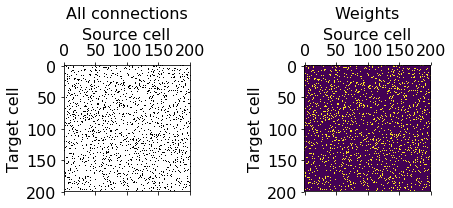

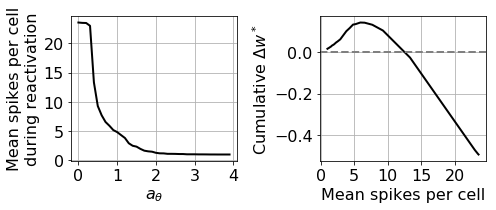

In [3]:
# PARAMS
M = 200
N_MAX = 200
Q = .1

T_THT = 10
A_THTS = np.arange(0, 4, .1)

I_STD_0 = 0  # BASELINE NOISE
I_STD_1 = 1  # REACTIVATION NOISE

np.random.seed(0)

# set up weights
cxn = np.random.rand(M, M) < Q
w_0 = np.zeros((M, M))
w_0[cxn] = W_MAX

# plot cxn matrices and weight matrices
fig, axs = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)
axs[0].spy(cxn)
axs[0].set_title('All connections\n\n')
axs[1].matshow(w_0, vmin=0, vmax=.15*W_MAX)
axs[1].set_title('Weights\n\n')

for ax in axs:
    ax.set_xlabel('Source cell')
    ax.set_ylabel('Target cell')
    ax.xaxis.set_label_position('top')
    set_font_size(ax, 16)

# set up inputs
n_t = 30
t_react = [5]
i_ext = I_STD_0 * np.random.randn(n_t, M)
i_ext[t_react, :] = I_STD_1 * np.random.randn(len(t_react), M)

# loop over adaptation rates
n_spk = []
d_w_s_avg = []

for a_tht in A_THTS:
    
    # build ntwk and run smln
    ntwk = BinarySTDPNtwk(
        cxn=cxn,
        w_0=w_0,
        tht_s=THT_S,
        t_tht=T_THT,
        a_tht=a_tht,
        n_max=N_MAX,
        t_stdp=cc([T_STDP_M, T_STDP_P]),
        d_w_s=cc([D_W_S_M, D_W_S_P]),
        w_min=W_MIN,
        w_max=W_MAX)

    rslt = ntwk.run(i_ext=i_ext, change_w=False)
    
    # compute avg # spks per nrn
    n_spk.append(rslt.spks.sum()/M)
    
    # compute average expected ∆w*
    d_w_s_avg.append(rslt.d_w_s.sum() / cxn.sum())
    

# plot spk ct vs adaptation rate, and ∆w* vs spk count
fig, axs = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)

axs[0].plot(A_THTS, n_spk, lw=2, c='k')
axs[0].set_xlabel(r'$a_\theta$')
axs[0].set_ylabel('Mean spikes per cell\nduring reactivation')

axs[1].plot(n_spk, d_w_s_avg, lw=2, c='k')
axs[1].axhline(0, color='gray', ls='--', lw=2)
axs[1].set_xlabel('Mean spikes per cell')
axs[1].set_ylabel(r'Cumulative $\Delta w^*$')

for ax in axs:
    ax.grid()
    set_font_size(ax, 16)

# Network with embedded ensemble

Reactivation without plasticity

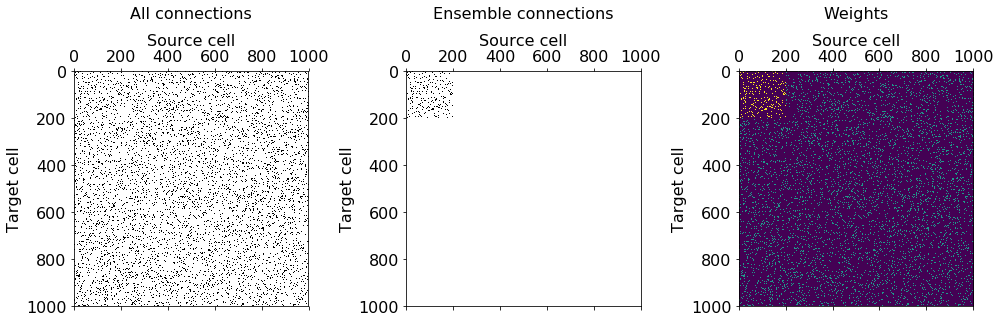

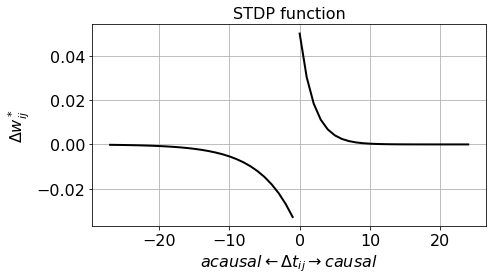

In [4]:
# PARAMS
N = 1000
M = 200
N_MAX = 200
Q = .1

I_STD_0 = .375  # BASELINE NOISE
I_STD_1 = .8  # REACTIVATION NOISE

np.random.seed(0)

# set up weights
cxn = np.random.rand(N, N) < Q
w_0 = np.zeros((N, N))
w_0[cxn] = W_MIN

# set up strongly connected ensemble
ens_mask = np.zeros(N, dtype=bool)
ens_mask[:M] = True
ens_cxn = cxn & np.outer(ens_mask, ens_mask)
w_0[ens_cxn] = W_MAX

# plot cxn matrices and weight matrices
fig, axs = plt.subplots(1, 3, figsize=(14, 5), tight_layout=True)
axs[0].spy(cxn)
axs[0].set_title('All connections\n\n')
axs[1].spy(ens_cxn)
axs[1].set_title('Ensemble connections\n\n')
axs[2].matshow(w_0, vmin=0, vmax=.15*W_MAX)
axs[2].set_title('Weights\n\n')

for ax in axs:
    ax.set_xlabel('Source cell')
    ax.set_ylabel('Target cell')
    ax.xaxis.set_label_position('top')
    set_font_size(ax, 16)

# plot STDP function
fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)
ax.plot(T_STDP_M, D_W_S_M, lw=2, c='k')
ax.plot(T_STDP_P, D_W_S_P, lw=2, c='k')
ax.set_xlabel(r'$acausal \leftarrow \Delta t_{ij} \rightarrow causal$')
ax.set_ylabel(r'$\Delta w^*_{ij}$')
ax.set_title('STDP function')

ax.grid()

set_font_size(ax, 16)

# set up inputs
n_t = 1000
t_react = [100, 900]
i_ext = I_STD_0 * np.random.randn(n_t, N)
i_ext[t_react, :] *= (I_STD_1/I_STD_0)

# set up save vars
t_save_w = [1, 199, 399, 599, 799, 999]
bins_p_w = np.linspace(W_MIN, W_MAX, 50)

# build ntwk and run smln
ntwk = BinarySTDPNtwk(
    cxn=cxn,
    w_0=w_0,
    tht_s=THT_S,
    t_tht=T_THT,
    a_tht=A_THT,
    n_max=N_MAX,
    t_stdp=cc([T_STDP_M, T_STDP_P]),
    d_w_s=cc([D_W_S_M, D_W_S_P]),
    w_min=W_MIN,
    w_max=W_MAX)

rslt = ntwk.run(i_ext=i_ext, t_save_w=t_save_w, bins_p_w=bins_p_w, change_w=None)

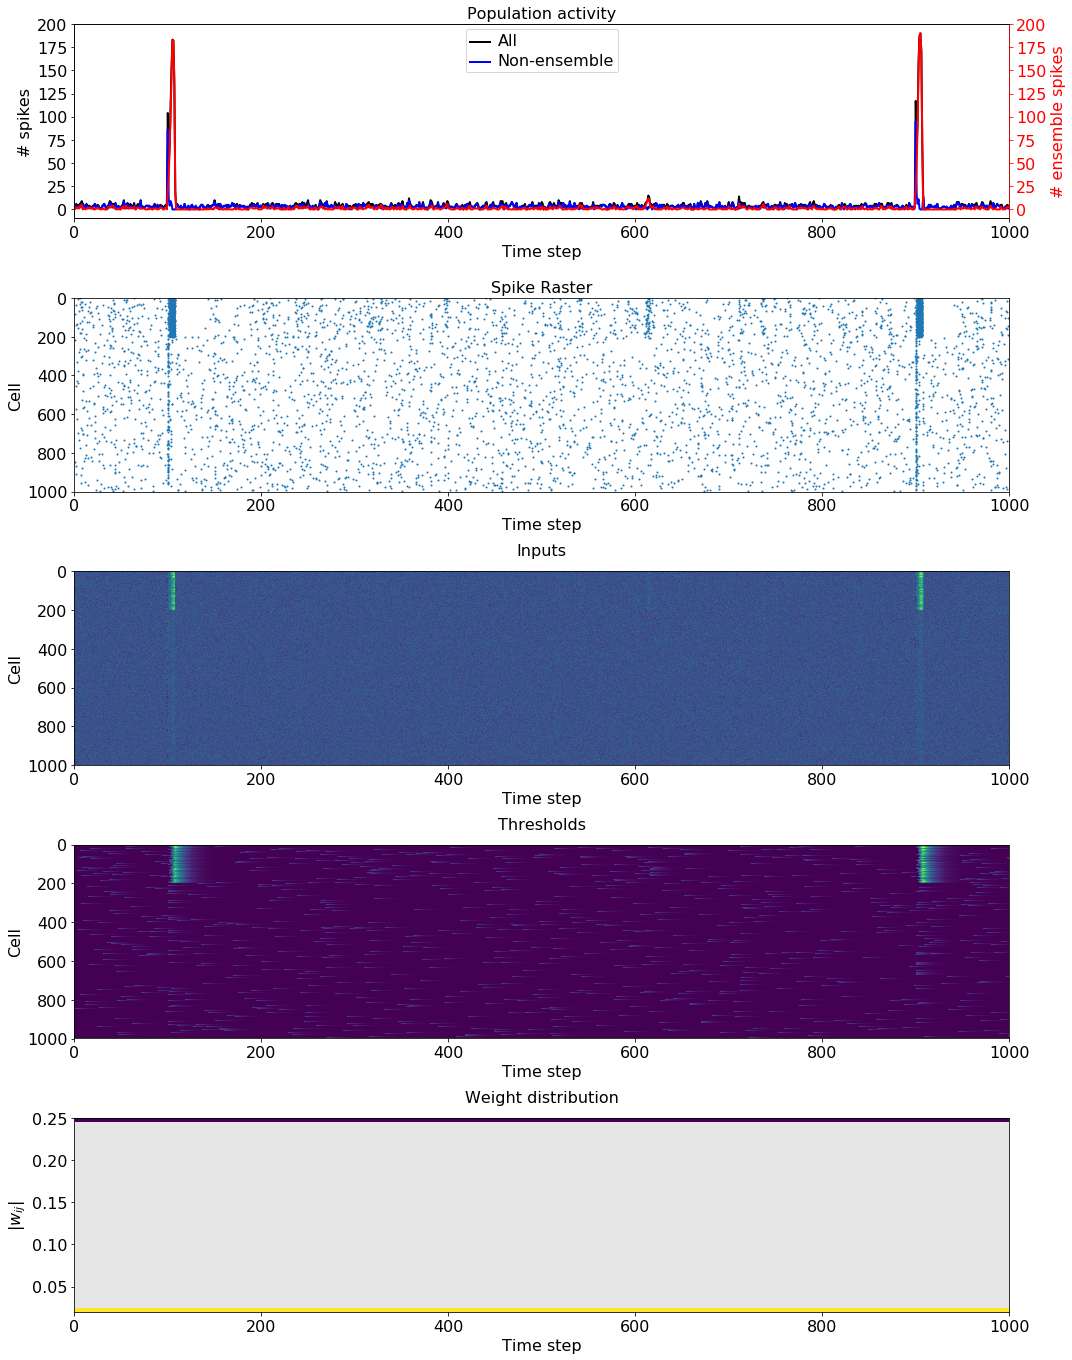

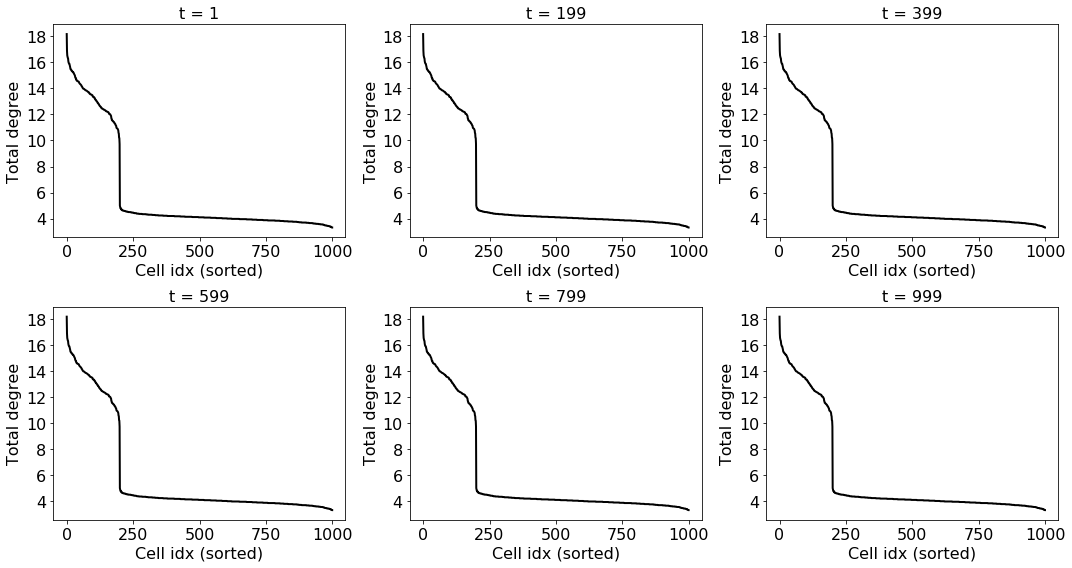

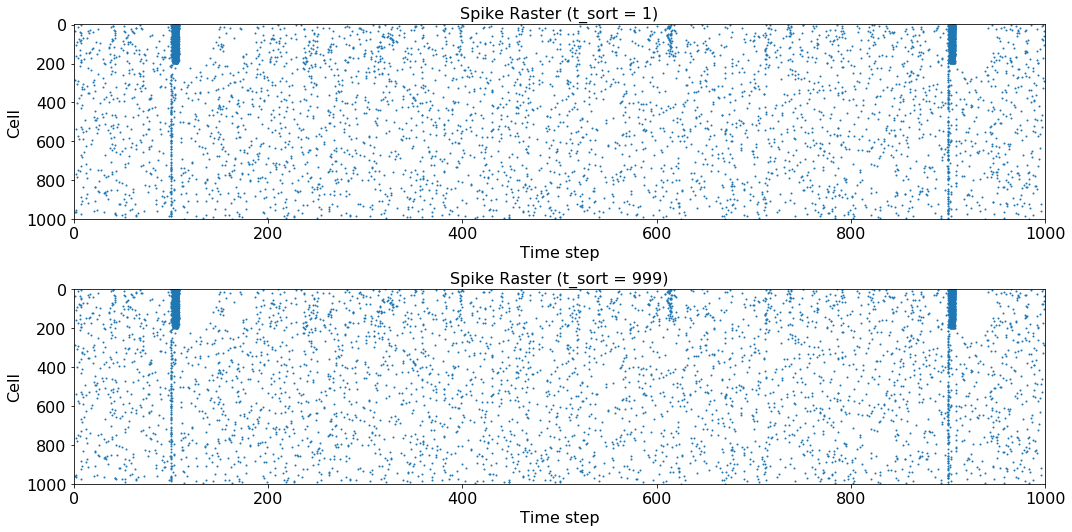

In [5]:
# plot dynamics and weight distribution
fig, axs = plt.subplots(5, 1, figsize=(15, 19), tight_layout=True)

## population activity
axs[0].plot(rslt.t, rslt.spks.sum(1), lw=2, color='k')
axs[0].plot(rslt.t, rslt.spks[:, ~ens_mask].sum(1), lw=2, color='b')
axs[0].set_xlim(0, n_t)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('# spikes')
axs[0].legend(['All', 'Non-ensemble'])
axs[0].set_title('Population activity')

ax_twin = axs[0].twinx()
ax_twin.plot(rslt.t, rslt.spks[:, ens_mask].sum(1), lw=2, color='r')
ax_twin.set_xlim(0, n_t)
ax_twin.set_ylabel('# ensemble spikes')

set_color(ax_twin, 'r')

## raster
axs[1].scatter(*np.nonzero(rslt.spks), s=1)
axs[1].set_xlim(0, n_t)
axs[1].set_ylim(N, -1)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Cell')
axs[1].set_title('Spike Raster')

## inputs
axs[2].matshow(rslt.vs.T, origin='upper', aspect='auto')
axs[2].xaxis.tick_bottom()
axs[2].set_xlim(0, n_t)
axs[2].set_xlabel('Time step')
axs[2].set_ylabel('Cell')
axs[2].set_title('Inputs')

## thresholds
axs[3].matshow(rslt.thts.T, origin='upper', aspect='auto')
axs[3].xaxis.tick_bottom()
axs[3].set_xlim(0, n_t)
axs[3].set_xlabel('Time step')
axs[3].set_ylabel('Cell')
axs[3].set_title('Thresholds')

## weight distr
axs[4].matshow(np.log(rslt.cts_w.T), origin='lower', aspect='auto', extent=[0, n_t, W_MIN, W_MAX])
axs[4].xaxis.tick_bottom()
axs[4].set_xlim(0, n_t)
axs[4].set_facecolor((.9, .9, .9))
axs[4].set_xlabel('Time step')
axs[4].set_ylabel(r'$|w_{ij}|$')
axs[4].set_title('Weight distribution')

for ax in list(axs) + [ax_twin]:
    set_font_size(ax, 16)
    
    
# plot degree vs sorted cell idx at chosen ts
fig, axs = fast_fig(len(t_save_w), (4, 5))

sorted_k = {}

for ax, t_ in zip(axs, t_save_w):

    # calc weighted degree
    k_out = rslt.ws[t_].sum(0)
    k_in = rslt.ws[t_].sum(1)
    k = k_out + k_in
    
    sorted_k[t_] = np.argsort(k)[::-1]
    
    ax.plot(sorted(k)[::-1], lw=2, color='k')
    ax.set_xticks([0, 250, 500, 750, 1000])
    ax.set_xlabel('Cell idx (sorted)')
    ax.set_ylabel('Total degree')
    ax.set_title('t = {}'.format(t_))

    set_font_size(ax, 16)
    
    
# plot rasters sorted by top-degree cells
T_SORT = [1, 999]

fig, axs = plt.subplots(len(T_SORT), 1, figsize=(15, 3.75*len(T_SORT)), tight_layout=True)

for ax, t_ in zip(axs, T_SORT):
    
    spk_t, spk_idx_0 = np.nonzero(rslt.spks)
    order = sorted_k[t_]
    spk_idx = np.argsort(order)[spk_idx_0]
    
    ax.scatter(spk_t, spk_idx, s=1)
    ax.set_xlim(0, n_t)
    ax.set_ylim(N, -1)
    ax.set_xlabel('Time step')
    ax.set_ylabel('Cell')
    ax.set_title('Spike Raster (t_sort = {})'.format(t_))

    set_font_size(ax, 16)